# Algorithmes Génétiques

![alt text](pics/dna-Genetic-Algorithm_3.jpg "Algorithmes Génétiques")

*(source de l'image: [pixabay](https://pixabay.com/de/illustrations/dna-evolution-dinosaurier-roboter-3778639/))*

## Le problème du voyageur de commerce (*travelling salesman problem*)

### Le problème à resoudre

Le problème du voyageur de commerce, ou *problème du commis voyageur*, est un problème d'optimisation qui consiste à déterminer, étant donné une liste de villes et les distances entre toutes les paires de villes, le plus court circuit qui passe par chaque ville une et une seule fois (source: [fr.wikipedia.org](https://fr.wikipedia.org/wiki/Probl%C3%A8me_du_voyageur_de_commerce)).

Les **règles** sont donc les suivantes :
1. Chaque ville doit être visitée exactement une fois
2. Le voyageur de commerce doit retourner à la ville de départ (la distance totale doit être calculée en conséquence !) 

![alt text](pics/TSP.png "Travelling salesman problem")

*(source de l'image: [physics.aps.org](https://physics.aps.org/articles/v10/s32))*

Il parait simple, non ?

Malgré la simplicité de l’énoncé, aujourd'hui **on ne connaît pas** d'algorithme permettant de trouver une solution exacte rapidement et qui fonctionne dans tous les cas !


**GOAL:** utiliser une algorithme génétique per trouver une bonne solution au problème !


### Algorithme génétiques Vs. le problème du voyageur de commerce

Commençons par les **définitions** d’un algorithme évolutionnaire reformulées dans le cadre du problème du voyageur de commerce :
- Gène : une ville (représentée par des coordonnées (x, y))
- Individu (alias "chromosome") : un chemin remplissant les conditions ci-dessus (il passe par toutes les villes exactement une fois, etc.)
- Population : une collection de chemins possibles (c'est-à-dire une collection d'individus)
- Parents : deux parcours qui se combinent pour créer un nouveau parcours
- Sélection : opération qui nous permettra de choisir une collection de parents qui sont utilisés pour créer notre prochaine population (créant ainsi la prochaine génération de routes)
- Fitness : une fonction qui nous indique à quel point chaque itinéraire est bon (dans notre cas, la longueur de la distante, la plus courte, le mieux)
- Croisement : opération qui nous permettre de mélanger deux individus (les parents) pour obtenir deux nouveaux individus (les enfants) qui remplaceront leurs parents dans la génération suivante
- Mutation : un moyen d'introduire des variations dans notre population. Dans notre exemple, on échangera au hasard deux villes sur un itinéraire
- Élitisme : un moyen de transmettre les meilleurs individus à la génération suivante (sans croisement ni mutations)

**Structure de l'algorithme** :

0. Importation des outils et création des classes (qui nous seront utiles par la suite)
1. Création de la population initiale (Génération 0)
2. Calcul de la fonction de fitness (pour classer les individus existants)
3. Sélectionner les parents (mating pool)
4. Croisement
5. Mutation
6. Repeat !

# On commence !

## 0. Importation des outils et création des classes

### Importation des outils

Nous commençons par importer les outils qui nous aideront à implémenter notre algorithme génétique

In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

Pour les plus curieux :
- **numpy** nous aidera à faire les calcules
- **pandas** nous aidera à stocker les données
- **matplotlib** nous aidera à afficher les résultats


### Définition de la structure des données

Comme nous devons trouver l’itinéraire le plus court entre une liste de villes, nous devons pouvoir garder cette information quelque part et connaître la distance entre les Villles. Ceci est fait grâce à la classe `City` ci-dessous.

Entre autres, cette classe nous offre la méthode pour calculer la distance entre deux villes. Pour simplicité, on calculera une simple distance à vol d’oiseau (distance euclidienne) entre les deux villes. 

**Exercice 1** : Complétez le code pour calculer la distance entre deux villes.

In [2]:
class City:
    def __init__(self, x, y, name="default_name"):
        self.x = x
        self.y = y
        self.name = name
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        # ToDo: à  completer !! (1 ligne de code)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

----
**Cellule de TEST**:  Si votre code fonctionne, la prochaine cellule devrait afficher **10.0**

In [3]:
test_City_A = City(10, 100)
test_City_B = City(16, 92)
dist_test = test_City_A.distance(test_City_B)
print("La distance entre les deux villes de test vaut :", dist_test)

La distance entre les deux villes de test vaut : 10.0


<details>
    <summary>Suggestion 1</summary>
1. En python, <code>**</code>  est l'operateur puissance (exemple : <code>x = 3 ** 2</code> -> x vaut 9)
</details>

<details>
    <summary>Suggestion 2</summary>
2. utilisez la fonction <code>np.sqrt(number)</code> pour calculer la racine carrée
</details>

<details>
    <summary>Suggestion 3</summary>
3. Théorème de Pythagore...
</details>

-

*donnez-vous votre langue au chat?* 👅🐱

<details>
    <summary>Solution</summary>
<code>distance = np.sqrt((xDis ** 2) + (yDis ** 2))</code>
</details>

---

### Fonction de "Fitness" 💪

Nous devons être en mesure de comparer des solutions pour reconnaître les bonnes de moins bonnes. Ceci est fait grâce à la classe `Fitness` ci-dessous.

Nous voulons trouver le parcours le plus court. Nous traiterons donc la fonction de fitness comme *l'**inverse** de la distance* du chemin analysé (plus la distance et grand, plus la fonction de fitness nous retournera une valeur petite).
Donc un score de fitness plus élevé est préférable !

Comme cette classe est relativement complexe nous vous fournissons le code. 

**Exercice 2** : essayez de comprendre le code de la classe Fitness (*si besoin, les explications sont en dessous du code*).


In [4]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

<details>
    <summary>Explication</summary>
    
Le principe est quand-même très simple. 
- La méthode `routeDistance()` somme, l’une après l’autre, les distances entre les villes rencontrer sur un parcours. Ceci est fait grâce à la méthode que vous venez de compléter. 
- La méthode `routeDistance()` inverse la valeur ainsi calculée ( `1 / float(self.routeDistance())` ).


Rappel : sur la base de la règle n° 2 (voir section "**Le Problème**"), nous devons commencer et finir dans la même ville. Ce calcul supplémentaire est pris en compte par les instructions

```
if i + 1 < len(self.route):
    toCity = self.route[i + 1]
else:
    toCity = self.route[0]
```
    
</details>

---

## 1. Création de la population initiale

À cette étape nous devons définir notre « Population ». 

On peut voir une Population comme un ensemble de solutions possibles que, en évoluant au cours des générations, se rapprocheront toujours plus de la meilleure solution possible. 

**Exercice 3** : Qu’est-ce que donc pour nous une "solution" ?

1. Une distance très petite
2. Une liste ordonnées des villes visitées (qui respecte les règles 1 et 2)
3. Aucune idée, mais c'est où le T-Rex ?

Clique sur `Réponse` ci-dessous pour valider votre choix
<details>
    <summary>Réponse</summary>
- [x] Une liste ordonnées des villes visité (qui respecte les règles 1 et 2)
</details>

---

**Exercice 4** : completez le code suivant pour créer un Itinéraire (route) qui à partire d'une liste de ville (le type n'est pas important) retourne une liste aleatoire

In [5]:
def createRoute(cityList):
    # ToDo: à  completer !!
    route = random.sample(cityList, len(cityList))
    return route

---
**Cellule de TEST**:  Si votre code fonctionne, la prochaine cellule devrait retourne une liste qui contienne **TOUTES** les villes dans un ordre aléatoire et sans répetitions

In [6]:
test_cityList = ["Brig", "Visp", "Sierre", "Sion", "Martigny", "LeResteDuMonde"]
test_route = createRoute(test_cityList)
print(test_route)

['Martigny', 'Sion', 'Brig', 'Sierre', 'LeResteDuMonde', 'Visp']


<details>
    <summary>Suggestion 1</summary>
    
investiguez la fonction `random.sample()` par exemple [ici](https://www.geeksforgeeks.org/python-random-sample-function/)
</details>

<details>
    <summary>Suggestion 2</summary>

    testez : len(cityList)
</details>

-

*donnez-vous votre langue au chat?* 👅🐱

<details>
    <summary>Solution</summary>
    
`route = random.sample(cityList, len(cityList))`
</details>

---

In [7]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

Remarque : nous n'avons qu'à utiliser ces fonctions pour créer la population initiale. Les générations suivantes seront produites par *reproduction* et *mutation*.

## 2. Calcul de la fonction de fitness

C’est le moment de passer à la deuxième étape. 

La fonction ` rankRoutes(population)` retourne les individus de manière ordonnée du meilleure ou pire car `reverse = true`. Ceci grâce à la classe `Fitness` (défini plus haut).




In [8]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

## 3. Sélectionner les parents

La fonction `selection (popRanked, eliteSize)` sauvegarde les « élites » dans une liste et sélectionne les autres individus avec une probabilité qui dépende de leur fitness (on fait ce qu’on appelle une « Sélection proportionnelle »

In [9]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Les individus sélectionnés seront les parents de la nouvelle génération. Dans la fonction ci-dessous, nous créons un *mating pool* (un pool d'accouplement) à partir de la fonction de sélection.
Le but est d’extraire les individus sélectionnés de notre population grâce aux IDs.

**Exercice 5** : 
- `population` contient l’ensemble des individus
- `selectionResult` contient les individus choisis par notre algorithme de sélection

Complétez le code ci-dessous pour prendre de la population les éléments sélectionnées auparavant et les ajouter (*append*) à la liste vide `matingpool = []`


In [10]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        # ToDo: à  completer !!
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

----
**Cellule de TEST**:  Si votre code fonctionne, la prochaine cellule devrait afficher *environ* **42** ou **80**

In [11]:
test_cityList = []
test_cityList.append(City(x=0, y=0, name="City A"))
test_cityList.append(City(x=0, y=1, name="City B"))
test_cityList.append(City(x=20, y=1, name="City C"))
test_cityList.append(City(x=20, y=0, name="City D"))
    
    
population_Test = initialPopulation(1000, test_cityList)
selectionResults_Test = [0]
mat_pool_test = matingPool(population_Test, selectionResults_Test)
print(1/Fitness(mat_pool_test[0]).routeFitness())



42.049968789001575


<details>
    <summary>Suggestion 1</summary>
    
`index = selectionResults[i]`
</details>

<details>
    <summary>Suggestion 2</summary>

`matingpool.append(???)`
</details>

-

*donnez-vous votre langue au chat?* 👅🐱

<details>
    <summary>Solution</summary>
<code>index = selectionResults[i]
matingpool.append(population[index])</code>

</details>

---

## 4. Croisement

Les fonctions `breed` et `breedPopulation` ci-dessous implémentent le croisement.

Comme chaque ville doit être visitée exactement une fois et la ville de départ et doit être également la dernière ville visitée, il faut implémenter une fonction de crossover particulière. 

Ici, on utilise une méthode appelée « croisement ordonnée » (*ordered crossover*). Ceci permet de mixer les villes visitées par les deux parents de manière aléatoire sans avoir des répétitions. Le principe est le suivant :
- on sélection au hasard un sous-ensemble de villes visitées à la suite du premier parent.
- cette sélection fera partie du génome du fis
- on remplissons le reste de la route avec les villes du deuxième parent dans l'ordre dans lequel elles apparaissent, sans dupliquer aucune ville 

Exemple : 

| Individu | Génome |
| ----------- | ----------- |
| Premier parent | Ville A, **Ville C**, **Ville D**, Ville B, Ville E |
| Deuxième parent | Ville B, Ville D, Ville E, Ville C, Ville A |
| Fis | Ville B, **Ville C, Ville D**, Ville E, Ville A |

En **gras**, les gènes sélectionnés du premier parent et transmis au fis (le reste vient du deuxème parent de manière ordonnée)



In [12]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

In [13]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

## 5. Mutation

Tous les individus de la nouvelle génération on une petite (ou grande) chance de naître avec des mutations. Ceci permet à l’algorithme de chercher des solutions que la génération précédente n’a pas explorées. 

Comme pour le croisement, les règles du problème nous imposent d’utiliser une méthodologie de mutation particulière : le *mutation swap*. Cela signifie que, pour chaque individu, deux villes échangeront leurs places sur notre itinéraire avec une probabilité définie par la variable `mutationRate`. Plus elle est grande, plus un individu est susceptible d'avoir une ou plusieurs mutations.

La fonction `mutatePopulation()` étend le même principe sur toute la population.

**Exercice 6** :
Complétez le code ci-dessous pour échanger (swap) deux villes de manière aléatoire dans le génome d'un individu.


In [14]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            # ToDo: à  completer !!
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

In [15]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

----
**Cellule de TEST**:  Si votre code fonctionne, la prochaine cellule devrait afficher environ **0.5**

In [16]:
import copy

individual_test_original = ['A', 'B']
individual_test = copy.deepcopy(individual_test_original)
counter = 0
mutationRate_test = 1 # we  set 50% probability to have a mutation
for i in range(0,1000):
    individual_test = mutate(individual_test, mutationRate_test)
    if individual_test == individual_test_original:
        counter = counter + 1
        
print(counter/1000)
    


0.505


<details>
    <summary>Suggestion 1</summary>
    
    Vous avez besoin de 4 lignes de codes...
</details>

<details>
    <summary>Suggestion 2</summary>
<code>city1 = individual[swapped]
 city2 = individual[swapWith]</code>

</details>

-

*donnez-vous votre langue au chat?* 👅🐱

<details>
    <summary>Solution</summary>
<code>city1 = individual[swapped]
 city2 = individual[swapWith]
 individual[swapped] = city2
 individual[swapWith] = city1</code>
</details>

---

## 6. Repeat

Nous avons maintenant toutes les pièces pour créer la nouvelle génération à partir de la génération courante.

**Exercice 7** :
Complétez le code ci-dessous en suivant les instructions suivantes :

1.	Classez les individus de la génération actuelle à l’aide de `rankRoutes()`
2.	Déterminez les parents potentiels en exécutant la fonction `selection()`
3.	Créez un mating pool grâce à la fonction `matingPool()`
4.	Créez la nouvelle génération à l'aide de la fonction `breedPopulation()`
5.	Appliquez les mutations à l'aide de la fonction `mutatePopulation()`

*Votre code sera testé dans la section suivante !!*
*Si vous vous avez des erreurs, regardez la solution après la cellule ci-dessous.*


In [17]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration
"""
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = # ToDo: à  completer !!
    selectionResults = # ToDo: à  completer !!
    matingpool = # ToDo: à  completer !!
    children = # ToDo: à  completer !!
    nextGeneration = # ToDo: à  completer !!
    return nextGeneration
"""

'\ndef nextGeneration(currentGen, eliteSize, mutationRate):\n    popRanked = # ToDo: à  completer !!\n    selectionResults = # ToDo: à  completer !!\n    matingpool = # ToDo: à  completer !!\n    children = # ToDo: à  completer !!\n    nextGeneration = # ToDo: à  completer !!\n    return nextGeneration\n'

<details>
    <summary>Solution</summary>
<code>def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration</code>
</details>

---

# Evolution !

C’est tout ! Il ne nous reste que rentrer les valeurs initiales des paramètres, la liste de villes (pour l’instant générée aléatoirement) et sauvegarder les informations qui nous intéressent. 

Nous sauvegarderons la distance initiale trouvé par la première génération et la distance finale trouvé par la dernière génération. 

**Exécuter les trois prochaines cellules et c’est parti !**

*PS : ça pourrait aussi prendre quelques minutes… c’est normal, pas de stress…*


In [18]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    initialRouteIndex = rankRoutes(pop)[0][0] # we select the best route of the first generation
    initialRoute = pop[initialRouteIndex]
    
    for i in range(0, generations):
        if i % 50 == 0:
            print("Generation: ", i)
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Evolution COMPLETED!!")
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute, initialRoute

In [19]:
cityList = []

for i in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

In [20]:
geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500);

Initial distance: 1908.899073268148
Generation:  0
Generation:  50
Generation:  100
Generation:  150
Generation:  200
Generation:  250
Generation:  300
Generation:  350
Generation:  400
Generation:  450
Evolution COMPLETED!!
Final distance: 872.9478068523619


# Plot

On dit que **une image vaut mille mots…** alors pourquoi se contenter de ces quelques chiffres ?

La fonction ci-dessous nous permettra de **voir** comment l'algorithme performe au passage des générations !

In [21]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        if i % 50 == 0:
            print("Generation: ", i)
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()


**Et c’est repartie pour un nouvel entrainement!**

Generation:  0
Generation:  50
Generation:  100
Generation:  150
Generation:  200
Generation:  250
Generation:  300
Generation:  350
Generation:  400
Generation:  450


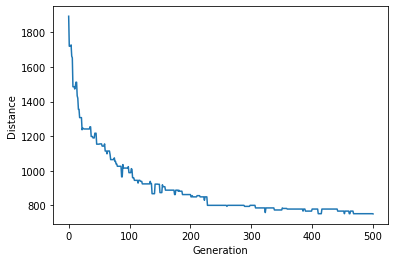

In [23]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

# Challenge the Evolution!

L’algorithme est complète, il apprend génération après génération et donne des réponses toujours meilleures… mais **pouvez-vous le battre ?**

Jouons avec les coordonnées des villes suisses. Savez-vous que les coordonnées officielles de la Suisse ne sont pas exprimées en latitude et longitude (au moins pas que ça).

*« En Suisse, l’origine du système se trouve à l’ancien observatoire astronomique de Berne. Les coordonnées sont comptées en mètres à partir de ce point : elles croissent vers l’est et le nord, décroissent vers l’ouest et le sud. Contrairement à ce que l’on aurait pu penser, l’origine ne s’est pas vu attribuer les coordonnées 0 m / 0 m, mais les valeurs :*

*E = 2 600 000 m (Est) et N = 1 200 000 m (Nord)*

*Cette définition permet d’éviter des coordonnées négatives au sud et à l’ouest de Berne sur le territoire suisse. Toute confusion entre les valeurs Est et Nord est également exclue. »*
(source [SwissTopo](https://www.swisstopo.admin.ch/fr/connaissances-faits/mensuration-geodesie/coordonnees/coordonnees-suisses.html))

##### Nous créons une nouvelle liste de villes

In [34]:
# Coordonnées Suisse
cityList_swiss = []
cityList_swiss.append(City(x=2592636, y= 1118564, name="Sion"))
cityList_swiss.append(City(x=2554092, y= 1145904, name="Vevey"))
cityList_swiss.append(City(x=2572184, y= 1106154, name="Martigny"))
cityList_swiss.append(City(x=2607280, y= 1126824, name="Sierre")) 
cityList_swiss.append(City(x=2600000, y= 1200000, name="Bern"))
cityList_swiss.append(City(x=2578142, y= 1183840, name="Fribourg")) 
cityList_swiss.append(City(x=2537781, y= 1152080 , name="Lausanne"))
cityList_swiss.append(City(x=2499950, y= 1118074, name="Geneva"))
cityList_swiss.append(City(x=2682624, y= 1248272, name="Zurich"))
cityList_swiss.append(City(x=2588096, y= 1147132, name="Gstaad"))



## Challenge: 

1. Trouvez le meilleur chemin à vol d’oiseaux entre la liste de villes ci-dessous.
2. Pouvez-vous battre l’algorithme génétique ? (spoiler: no, you can't  :-P)
3. Comparez votre solutions à la solution affichée par les prochaines cellules


##### On cherche la meilleure solution dans la liste des villes suisses

In [35]:
bestRoute, initialRoute = geneticAlgorithm(population=cityList_swiss, popSize=20, eliteSize=3, mutationRate=0.01, generations=500)

Initial distance: 573526.530304864
Generation:  0
Generation:  50
Generation:  100
Generation:  150
Generation:  200
Generation:  250
Generation:  300
Generation:  350
Generation:  400
Generation:  450
Evolution COMPLETED!!
Final distance: 516421.31002330495


##### On écrit une fonction pour afficher les villes dans un graphique très simple (scatter plot)

In [36]:
def printRoute(cityList, route=[], show_solution = False):
    x_coo = []
    y_coo = []
    cityNames = []

    for city in cityList:
        x_coo.append(city.x)
        y_coo.append(city.y)
        cityNames.append(city.name)

    plt.scatter(x=x_coo, y=y_coo, marker='o')
    for i, txt in enumerate(cityNames):
        plt.annotate(txt, (x_coo[i], y_coo[i]), fontsize=14)

    if show_solution is True:
        lastStop = len(route)-1
        for i in range(1, len(route)):
            x=[bestRoute[i-1].x,route[i].x]
            y=[bestRoute[i-1].y,route[i].y]
            plt.plot(x, y, 'ro-')

        x=[route[lastStop].x,route[0].x]
        y=[route[lastStop].y,route[0].y]
        plt.plot(x, y, 'ro-')

    plt.show()

##### On affiche les villes sans devoiler la solution

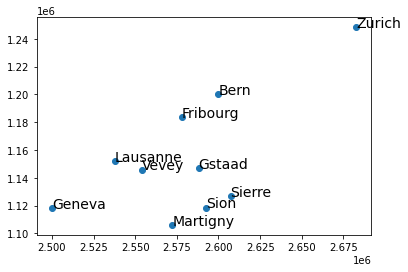

In [37]:
printRoute(cityList_swiss)

---
##### donnez-vous votre langue au chat? 👅🐱

##### On dessine la meilleure route trouvée à la première génération

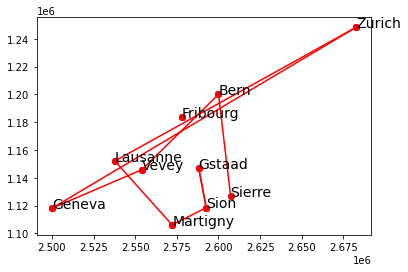

In [38]:
printRoute(cityList_swiss, initialRoute, show_solution=True)


#### On dessine la meilleure route trouvée à la dernière génération

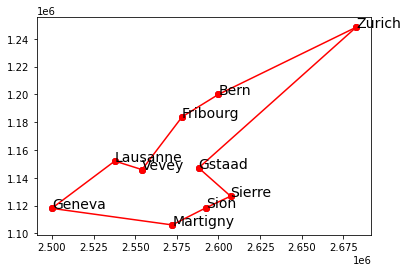

In [39]:
printRoute(cityList_swiss, bestRoute, show_solution=True)

### Optionnel :
- Faites un plot des performances de l’algo sur les villes suisses (cela vous montrera pourquoi vous ne pouviez pas le battre)
- Pour prendre votre revanche, essayez de changer le nombre de générations et les autres paramètres (population size, nombre de générations, etc.) et comparez les résultats
- Ajoutez ou supprimez des autres villes dans la liste `cityList_swiss = []`
   + allez sur https://map.geo.admin.ch/
   + cliquez avec le bouton droit sur l’emplacement désiré
   + reprenez les coordonnées dans le format CH1903+ / LV95 (voir image ci-dessous)

![alt text](pics/SwissCoo.png "Exemple coordonnées Martigny")


## References

1. Article original by [Eric Stoltz - Evolution of a salesman](https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35). Kudos to him!
2. Algorithmes génétiques - Wikipedia: [fr.wikipedia.org/wiki/Algorithme_génétique](https://fr.wikipedia.org/wiki/Algorithme_g%C3%A9n%C3%A9tique)
3. Problème du voyageur de commerce - Wikipedia: [fr.wikipedia.org/wiki/Problème_du_voyageur_de_commerce](https://fr.wikipedia.org/wiki/Probl%C3%A8me_du_voyageur_de_commerce)